In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Project paths
PROJECT_ROOT = '/content/drive/MyDrive/SU Works/CPSC_5310_Project'
DATA_PATH = os.path.join(PROJECT_ROOT, 'saved_data')
figures_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/docs/figures/'

# Input files
TRAIN_FILE = os.path.join(DATA_PATH, 'train_raw.parquet')
TEST_FILE = os.path.join(DATA_PATH, 'test_raw.parquet')


# Output files
TRAIN_SAVE_FILE = os.path.join(DATA_PATH, 'baseline_training.parquet')
TEST_SAVE_FILE = os.path.join(DATA_PATH, 'baseline_testing.parquet')

# Cluster Numer
NUM_CLUSTERS = 150

In [4]:
df_train = pd.read_parquet(TRAIN_FILE)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26859749 entries, 0 to 26859748
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int8          
 1   tpep_pickup_datetime   datetime64[ms]
 2   tpep_dropoff_datetime  datetime64[ms]
 3   passenger_count        int8          
 4   trip_distance          float32       
 5   pickup_longitude       float32       
 6   pickup_latitude        float32       
 7   RateCodeID             int8          
 8   store_and_fwd_flag     category      
 9   dropoff_longitude      float32       
 10  dropoff_latitude       float32       
 11  payment_type           int8          
 12  fare_amount            float32       
 13  extra                  float32       
 14  mta_tax                float32       
 15  tip_amount             float32       
 16  tolls_amount           float32       
 17  improvement_surcharge  float32       
 18  total_amount        

In [6]:
df_train['is_airport'] = df_train['RateCodeID'].isin([2, 3]).astype(int)

In [7]:
agg_df = df_train.groupby(['pickup_cluster', pd.Grouper(key='tpep_pickup_datetime', freq='h')]).agg({
    'VendorID': 'count',              # Demand Count (Volume)
    'total_amount': 'sum',            # Total Revenue (Value)
    'trip_distance': 'sum',           # Total Miles
    'trip_duration_min': 'sum',       # Total "Engaged" Minutes
    'speed_mph': 'mean',              # Congestion Signal (Speed)
    'is_airport': 'sum',              # Airport Trip Density
    'passenger_count': 'sum'          # People Flow
}).reset_index()

In [8]:
# Rename the aggregated features for more clarity
agg_df = agg_df.rename(columns={
    'tpep_pickup_datetime': 'timestamp',
    'VendorID': 'demand_count',
    'total_amount': 'total_revenue',
    'trip_duration_min': 'total_engaged_minutes',
    'is_airport': 'airport_trip_count'
})

In [9]:
# Calculate RPM (Revenue Per Minute)
agg_df['rpm'] = (agg_df['total_revenue'] /
                 agg_df['total_engaged_minutes'].replace(0, 1))

agg_df['profit_index'] = agg_df['total_revenue'] * agg_df['rpm']

In [10]:
all_clusters = range(NUM_CLUSTERS)
all_hours = pd.date_range(start=df_train['tpep_pickup_datetime'].min().floor('h'),
                          end=df_train['tpep_pickup_datetime'].max().floor('h'),
                          freq='h')

multi_index = pd.MultiIndex.from_product([all_clusters, all_hours], names=['pickup_cluster', 'timestamp'])
full_grid = pd.DataFrame(index=multi_index).reset_index()

final_train_df = pd.merge(full_grid, agg_df, on=['pickup_cluster', 'timestamp'], how='left')

cols_to_zero = ['demand_count', 'total_revenue', 'trip_distance', 'total_engaged_minutes', 'airport_trip_count', 'passenger_count']
final_train_df[cols_to_zero] = final_train_df[cols_to_zero].fillna(0)

# Calculate median speed from existing non-null speed values
median_speed = final_train_df['speed_mph'].median()

# For speed, if no trips happened, fill with median speed
final_train_df['speed_mph'] = final_train_df['speed_mph'].fillna(median_speed)
final_train_df['rpm'] = final_train_df['rpm'].fillna(0)
final_train_df['profit_index'] = final_train_df['profit_index'].fillna(0)

In [11]:
df_train = final_train_df.copy()
del agg_df, full_grid, multi_index, all_clusters, all_hours

In [12]:
print(df_train.isnull().sum())

pickup_cluster           0
timestamp                0
demand_count             0
total_revenue            0
trip_distance            0
total_engaged_minutes    0
speed_mph                0
airport_trip_count       0
passenger_count          0
rpm                      0
profit_index             0
dtype: int64


In [13]:
index_ceiling = df_train['profit_index'].quantile(0.99)
df_train['profit_index'] = df_train['profit_index'].clip(upper=index_ceiling)

In [14]:
print(df_train.isnull().sum())

pickup_cluster           0
timestamp                0
demand_count             0
total_revenue            0
trip_distance            0
total_engaged_minutes    0
speed_mph                0
airport_trip_count       0
passenger_count          0
rpm                      0
profit_index             0
dtype: int64


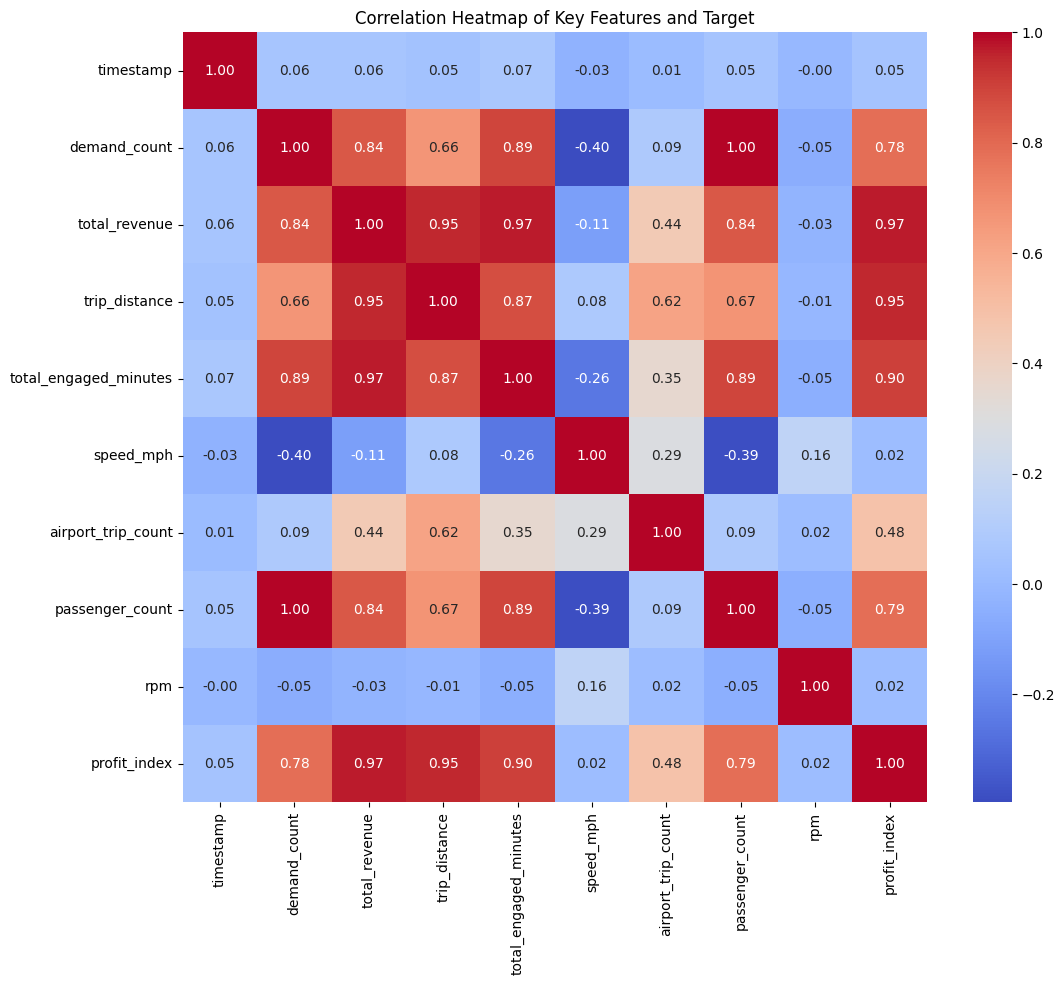

In [15]:
plt.figure(figsize=(12, 10))
selected_cols = [
    'timestamp',
    'demand_count',
    'total_revenue',
    'trip_distance',
    'total_engaged_minutes',
    'speed_mph',
    'airport_trip_count',
    'passenger_count',
    'rpm',
    'profit_index',
]
sns.heatmap(df_train[selected_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Key Features and Target')
plt.show()

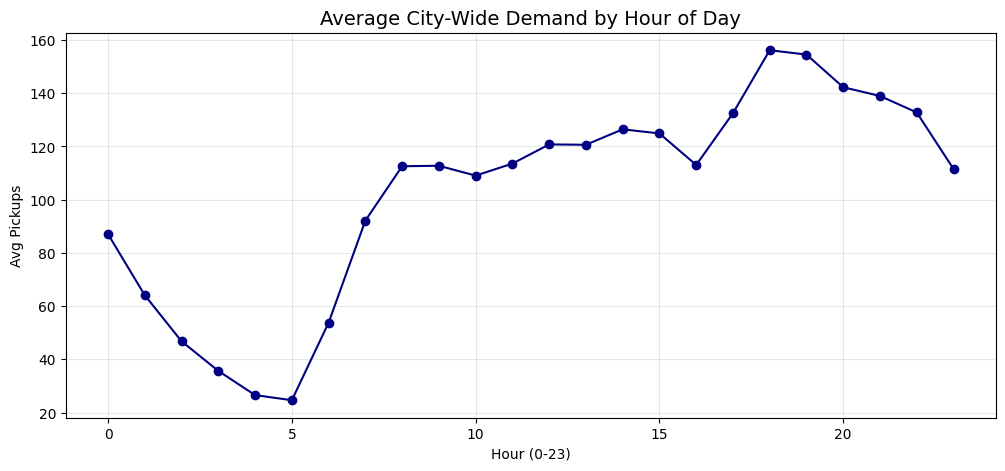

In [16]:
plt.figure(figsize=(12, 5))
df_train.groupby(df_train['timestamp'].dt.hour)['demand_count'].mean().plot(kind='line', marker='o', color='navy')
plt.title('Average City-Wide Demand by Hour of Day', fontsize=14)
plt.xlabel('Hour (0-23)')
plt.ylabel('Avg Pickups')
plt.grid(True, alpha=0.3)
plt.show()

# Target Generation

In [17]:
df_train['target_profit_next_hour'] = df_train.groupby('pickup_cluster')['profit_index'].shift(-1)

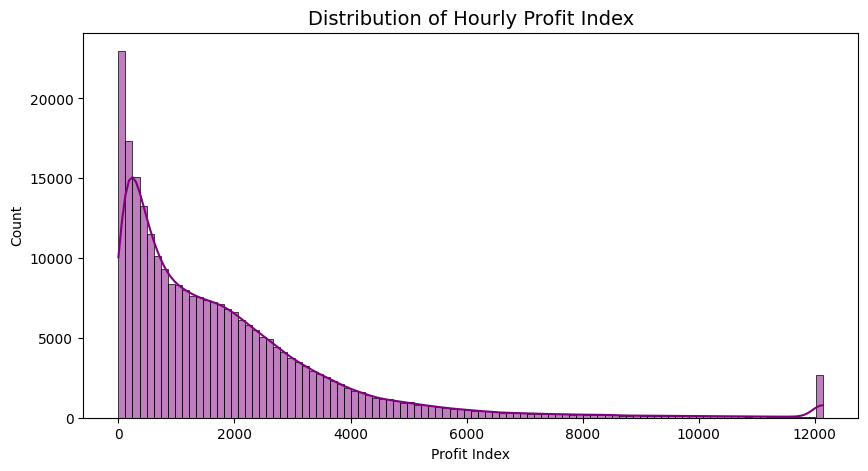

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train['target_profit_next_hour'], bins=100, kde=True, color='purple')
plt.title('Distribution of Hourly Profit Index', fontsize=14)
plt.xlabel('Profit Index')
plt.show()

In [19]:
active_profits = df_train[df_train['target_profit_next_hour'] > 0]['target_profit_next_hour']
thresholds = active_profits.quantile([0.1, 0.325, 0.55, 0.775]).values
thresholds

array([ 168.51496467,  701.73027792, 1570.6664607 , 2737.84049627])

In [20]:
def get_revenue_class(val):
    if pd.isna(val) or val <= thresholds[0]:
        return 1 # Class 1: Very Low Profit/ Zero Activity
    if val <= thresholds[1]:
        return 2 # Class 2: Low Profit
    if val <= thresholds[2]:
        return 3 # Class 3: Medium Profit
    if val <= thresholds[3]:
        return 4 # Class 4: High Profit
    return 5     # Class 5: Very High Profit

# Apply the labels
df_train['revenue_class'] = df_train['target_profit_next_hour'].apply(get_revenue_class)

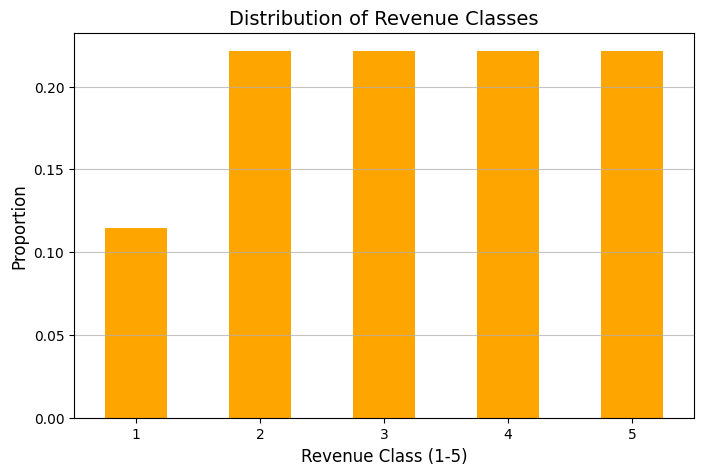

In [21]:
plt.figure(figsize=(8, 5))
df_train['revenue_class'].value_counts(normalize=True).sort_index().plot(kind='bar', color='orange')
plt.title('Distribution of Revenue Classes', fontsize=14)
plt.xlabel('Revenue Class (1-5)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.75)
plt.savefig(os.path.join(figures_path, "class_dist.svg"), format='svg', bbox_inches='tight')
plt.show()

In [22]:
def create_time_features(df_input):
    df = df_input.copy()
    # Extract the raw Day of Week (0=Monday, 6=Sunday)
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['hour'] = df['timestamp'].dt.hour

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_blizzard'] = ((df['timestamp'] >= '2016-01-22') &
                               (df['timestamp'] <= '2016-01-25')).astype(int)
    return df

df_train = create_time_features(df_train)

In [23]:
df_train = df_train.sort_values(['pickup_cluster', 'timestamp']).reset_index(drop=True)

In [24]:
def create_lags(df, vars_to_lag, lags):
    for var in vars_to_lag:
        for lag in lags:
            df[f'{var}_lag_{lag}'] = df.groupby('pickup_cluster')[var].shift(lag)
    return df

def create_rolling_stats(df, vars_to_roll, windows):
    for var in vars_to_roll:
        for window in windows:
            # We use 'shift(1)' because at time 't', we only know
            # the average of 't-1' and before. No looking into the future!
            df[f'{var}_rolling_mean_{window}'] = df.groupby('pickup_cluster')[var].transform(
                lambda x: x.shift(1).rolling(window=window).mean()
            )
    return df

In [25]:
lags_to_create = [1, 2, 24, 168]
features_to_lag = ['demand_count', 'revenue_class', 'speed_mph', 'airport_trip_count']
df_train = create_lags(df_train, features_to_lag, lags_to_create)
df_train = df_train.dropna().reset_index(drop=True)


df_train = create_rolling_stats(df_train, ['demand_count', 'profit_index', 'speed_mph', 'airport_trip_count'], [3, 8, 24])
df_train = df_train.dropna().reset_index(drop=True)

In [26]:
cols_to_drop = [
    'target_profit_next_hour',
    'total_revenue',
    'rpm',
    'passenger_count',         # Redundant with demand_count (high multicolinearity)
    'trip_distance'
]

df_train = df_train.drop(columns=cols_to_drop)

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233850 entries, 0 to 233849
Data columns (total 44 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   pickup_cluster                      233850 non-null  int64         
 1   timestamp                           233850 non-null  datetime64[ns]
 2   demand_count                        233850 non-null  float64       
 3   total_engaged_minutes               233850 non-null  float64       
 4   speed_mph                           233850 non-null  float64       
 5   airport_trip_count                  233850 non-null  float64       
 6   profit_index                        233850 non-null  float64       
 7   revenue_class                       233850 non-null  int64         
 8   day_of_week                         233850 non-null  int32         
 9   hour                                233850 non-null  int32         
 10  hour_sin

# Test Set

In [28]:
df_test_raw = pd.read_parquet(TEST_FILE)
final_train_df['timestamp'].max()

Timestamp('2016-03-13 23:00:00')

In [29]:
buffer = final_train_df[final_train_df['timestamp'] >= (final_train_df['timestamp'].max() - pd.Timedelta(hours=24))]

In [30]:
df_test_raw['is_airport'] = df_test_raw['RateCodeID'].isin([2, 3]).astype(int)

In [31]:
test_agg = df_test_raw.groupby(['pickup_cluster', pd.Grouper(key='tpep_pickup_datetime', freq='h')]).agg({
    'VendorID': 'count',
    'total_amount': 'sum',
    'trip_distance': 'mean',
    'trip_duration_min': 'sum',
    'speed_mph': 'mean',
    'passenger_count': 'sum',
    'is_airport': 'sum'
}).reset_index().rename(columns={
    'tpep_pickup_datetime': 'timestamp',
    'VendorID': 'demand_count',
    'total_amount': 'total_revenue',
    'trip_duration_min': 'total_engaged_minutes',
    'is_airport': 'airport_trip_count'
})

In [32]:
test_agg['rpm'] = test_agg['total_revenue'] / test_agg['total_engaged_minutes'].replace(0, 1)
test_agg['profit_index'] = test_agg['total_revenue'] * test_agg['rpm']

In [33]:
print(test_agg['timestamp'].min())
print(test_agg['timestamp'].max())

test_hours = pd.date_range(
    start=test_agg['timestamp'].min(),
    end=test_agg['timestamp'].max(),
    freq='h'
)

2016-03-14 00:00:00
2016-03-31 23:00:00


In [34]:
all_clusters = range(NUM_CLUSTERS)
multi_index = pd.MultiIndex.from_product(
    [all_clusters, test_hours],
    names=['pickup_cluster', 'timestamp']
)
test_grid = pd.DataFrame(index=multi_index).reset_index()

In [35]:
test_agg_full = pd.merge(test_grid, test_agg, on=['pickup_cluster', 'timestamp'], how='left')

In [36]:
test_agg_full[cols_to_zero] = test_agg_full[cols_to_zero].fillna(0)

In [37]:
lags_to_create = [1, 2, 24, 168]
features_to_lag = ['demand_count', 'revenue_class', 'speed_mph', 'airport_trip_count']
rolling_windows = [3, 8, 24]
cols_to_drop = [
    'target_profit_next_hour',
    'total_revenue',
    'rpm',
    'passenger_count',
    'trip_distance'
]

In [38]:
test_combined = pd.concat([buffer, test_agg_full], axis=0).sort_values(['pickup_cluster', 'timestamp'])


In [39]:
test_combined = create_time_features(test_combined)
test_combined = test_combined.sort_values(['pickup_cluster', 'timestamp']).reset_index(drop=True)

In [40]:
test_combined['target_profit_next_hour'] = test_combined.groupby('pickup_cluster')['profit_index'].shift(-1)
test_combined['revenue_class'] = test_combined['target_profit_next_hour'].apply(get_revenue_class)

In [41]:
test_combined = create_lags(test_combined, features_to_lag, lags_to_create)
test_combined = create_rolling_stats(test_combined, ['demand_count', 'profit_index', 'speed_mph', 'airport_trip_count'], rolling_windows)
test_combined = test_combined.dropna().reset_index(drop=True)

In [42]:
df_test = test_combined[test_combined['timestamp'] >= '2016-03-14'].copy()

In [43]:
df_test = df_test.drop(columns=cols_to_drop)

In [44]:
print(f"Final Train Shape: {df_train.shape}")
print(f"Final Test Shape: {df_test.shape}")
df_test = df_test[df_train.columns]
print(f"Columns match Training? {list(df_train.columns) == list(df_test.columns)}")

Final Train Shape: (233850, 44)
Final Test Shape: (39445, 44)
Columns match Training? True


In [45]:
pd.DataFrame({'df_train_columns': df_train.columns, 'df_test_columns': df_test.columns})

,df_train_columns,df_test_columns
0,pickup_cluster,pickup_cluster
1,timestamp,timestamp
2,demand_count,demand_count
3,total_engaged_minutes,total_engaged_minutes
4,speed_mph,speed_mph
5,airport_trip_count,airport_trip_count
6,profit_index,profit_index
7,revenue_class,revenue_class
8,day_of_week,day_of_week
9,hour,hour


In [46]:
# Save the Training set
df_train.to_parquet(TRAIN_SAVE_FILE)

# Save the Test set
df_test.to_parquet(TEST_SAVE_FILE)